In [46]:
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import os

In [47]:
import pandas as pd

path_df = '../data/loan_approval_dataset.csv'

df = pd.read_csv(path_df)
# Xóa các khoảng trắng tại mỗi cột

df.columns = df.columns.str.strip()
df.columns

# Xóa khoảng trắng ở tất cả giá trị trong df 
# df = df.applymap(lambda x : x.strip() if isinstance(x,str) else x)

df = df.map(lambda x: x.strip() if isinstance(x,str) else x) # Đối với Dataframe thì nên dùng map

# Câu lệnh sẽ lặp qua từng cột, kiểm tra xem kiểu giá trị đó - Nếu là string sẽ xóa dấu cách 


df = df.drop(['loan_id'],axis=1)
df.education.unique()

array(['Graduate', 'Not Graduate'], dtype=object)

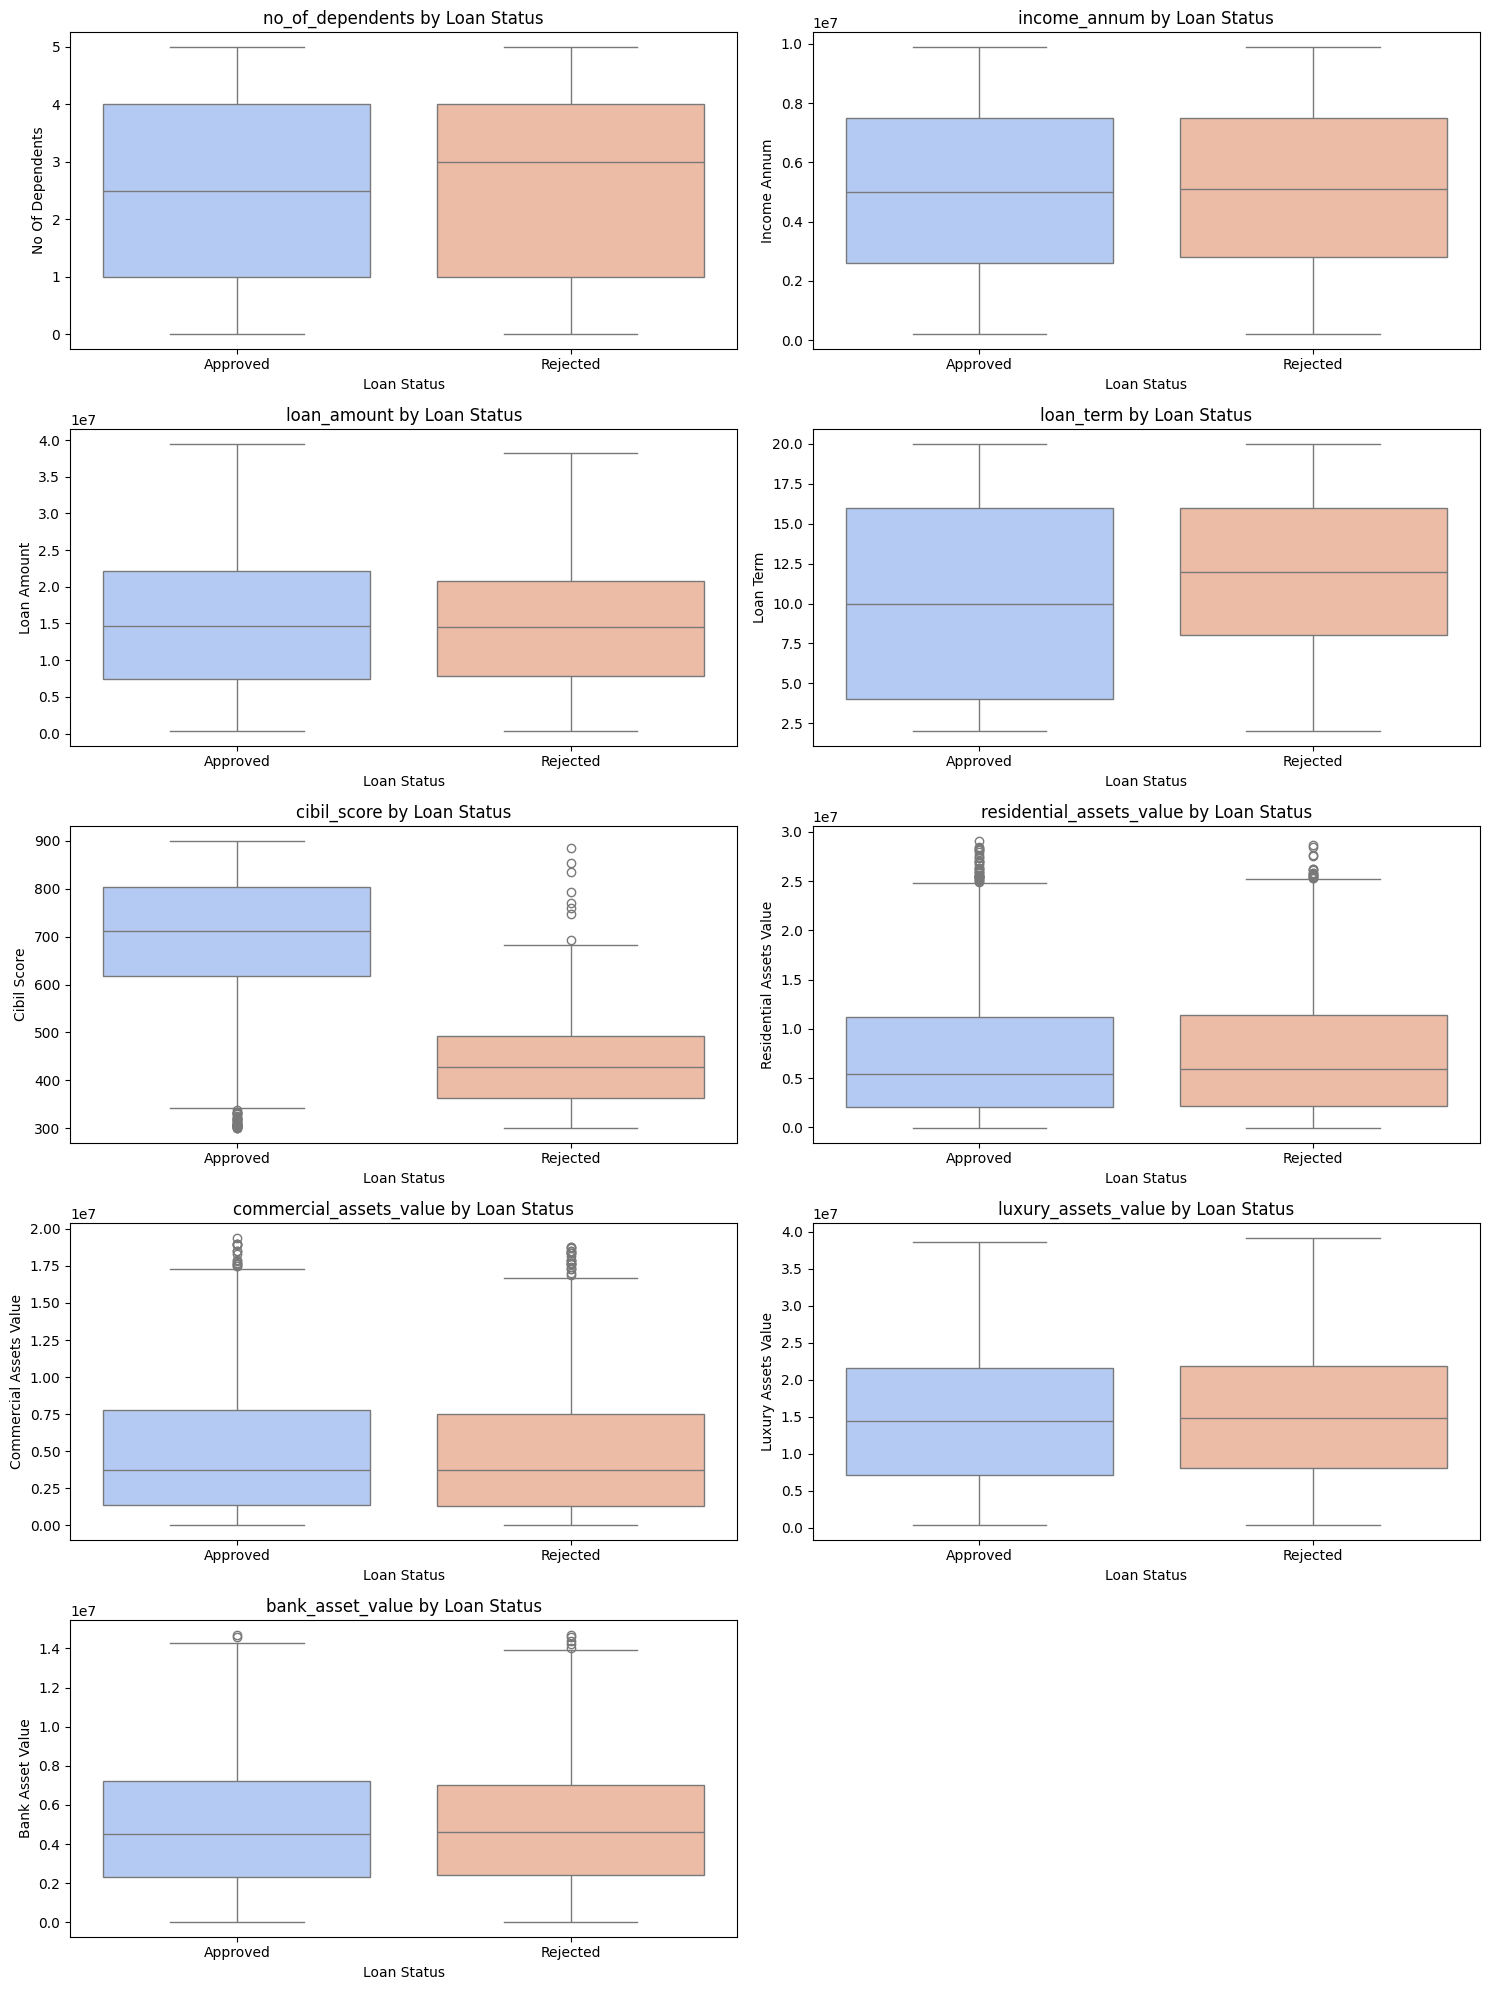

In [48]:
numeric_cols = df.drop(['education','self_employed','loan_status'],axis=1).columns
numeric_cols

plt.figure(figsize=(15,20))
for i, col in enumerate(numeric_cols,1):
    plt.subplot(5,2,i)
    sns.boxplot(x='loan_status',hue='loan_status',y=col,data=df,legend=False,palette='coolwarm')
    plt.title(f'{col} by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel(col.replace('_',' ').title())
plt.tight_layout()
plt.show()

#### Nhận xét 
1. Đánh giá trực quan dữ liệu tác động đến biến mục tiêu Loan_status: <br>
- 
2. Tại các trường residential_assets_value, commercial_assets_value, luxury_assets_value, bank_assets_value có các yếu tố sau <br>
- Có sự tương đồng IQR và trung vị ở cả 2 nhóm Approved, Rejected <br>
=> Không có sự khác biệt rõ rệt về hình dạng biểu đổ <br>
=> Tiên đoán : <br>
- Dữ liệu đơn biến
- Đều là tải sản của cá nhân 


## Thực hiện tính tổng <br> Assets = residential_assets_value + commercial_assets_value + luxury_assets_value + bank_assets_value

In [49]:
df['Assets'] = df.residential_assets_value + df.commercial_assets_value + df.luxury_assets_value + df.bank_asset_value
df = df.drop(['residential_assets_value','commercial_assets_value','luxury_assets_value','bank_asset_value'],axis=1)
df

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,loan_status,Assets
0,2,Graduate,No,9600000,29900000,12,778,Approved,50700000
1,0,Not Graduate,Yes,4100000,12200000,8,417,Rejected,17000000
2,3,Graduate,No,9100000,29700000,20,506,Rejected,57700000
3,3,Graduate,No,8200000,30700000,8,467,Rejected,52700000
4,5,Not Graduate,Yes,9800000,24200000,20,382,Rejected,55000000
...,...,...,...,...,...,...,...,...,...
4264,5,Graduate,Yes,1000000,2300000,12,317,Rejected,7400000
4265,0,Not Graduate,Yes,3300000,11300000,20,559,Approved,20000000
4266,2,Not Graduate,No,6500000,23900000,18,457,Rejected,39000000
4267,1,Not Graduate,No,4100000,12800000,8,780,Approved,28800000


### Đánh giá tương quan dữ liệu

<function matplotlib.pyplot.show(close=None, block=None)>

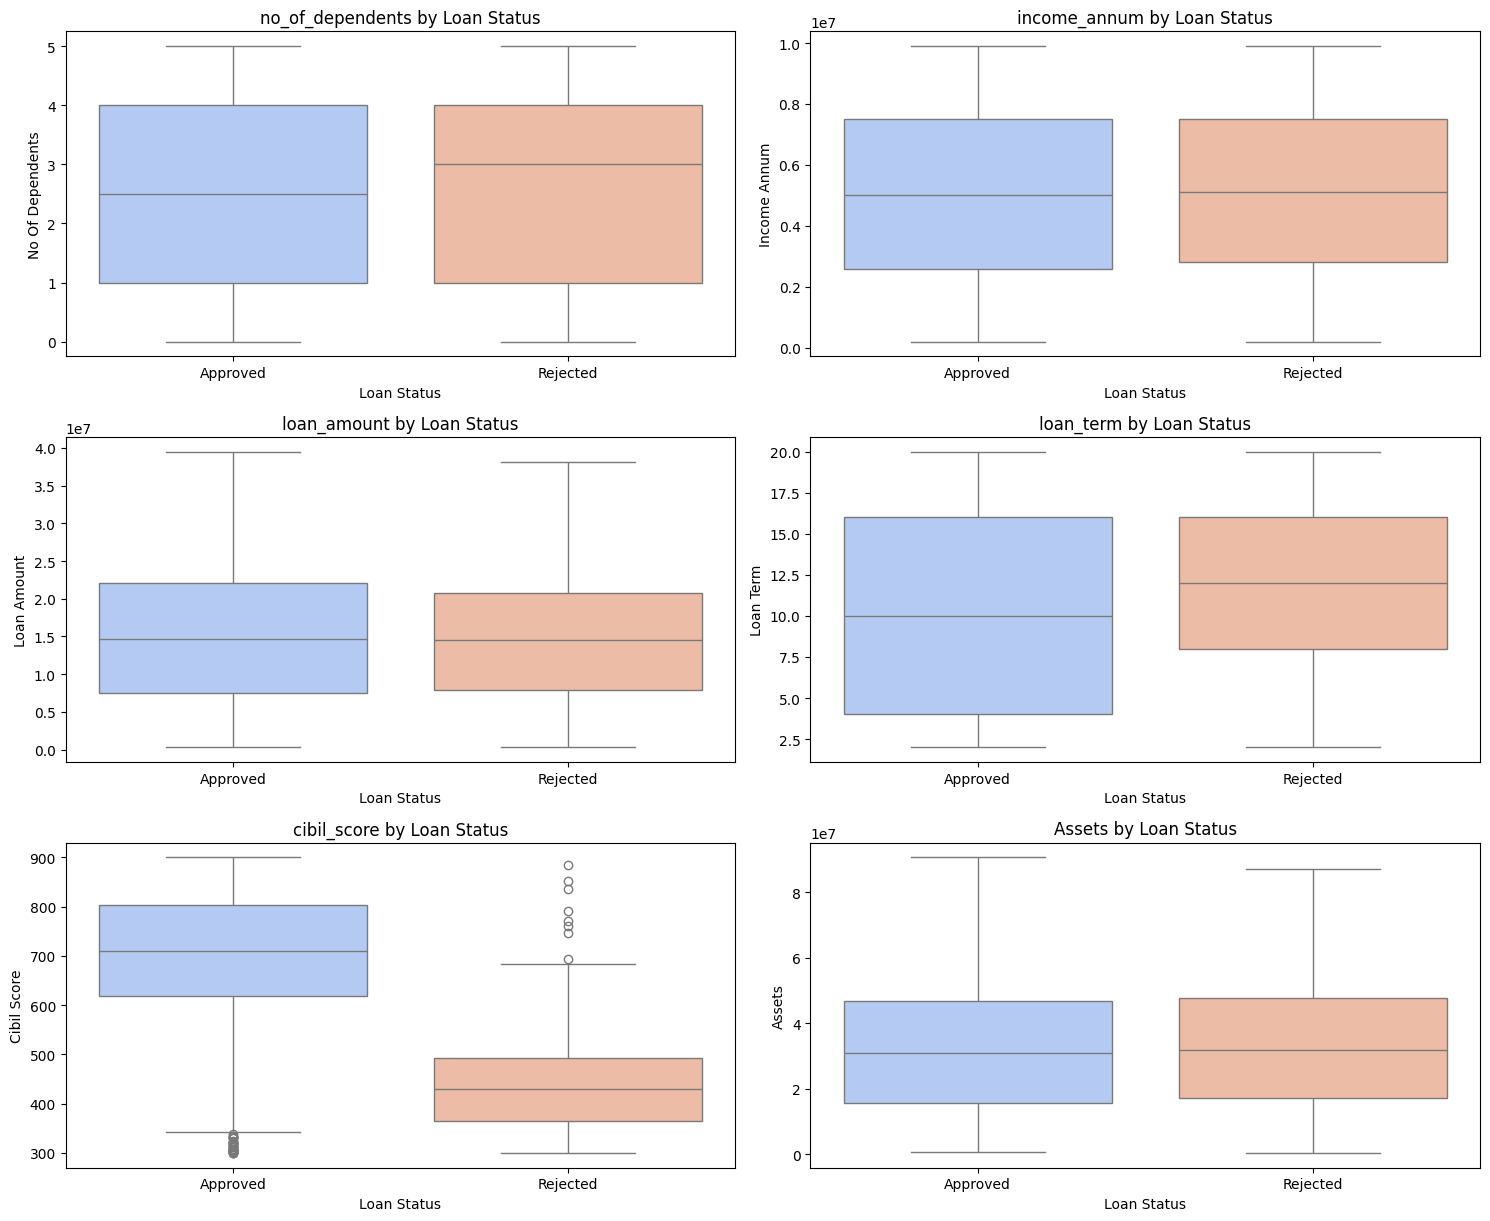

In [50]:
numeric_col = list(df.columns)
numeric_col.remove('education')
numeric_col.remove('self_employed')
numeric_col.remove('loan_status')
numeric_col


plt.figure(figsize=(15,20))
for i,col in enumerate(numeric_col,1):
    plt.subplot(5,2,i)
    sns.boxplot(x='loan_status',hue='loan_status', y=col, data=df,palette='coolwarm',legend=False)
    plt.title(f'{col} by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel(col.replace('_',' ').title())
plt.tight_layout()
plt.show

In [51]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

cat_colums = ['education', 'self_employed']
mapping_dict = {}
for i in cat_colums:
    label_encoder.fit(df[i])
    classes = label_encoder.classes_
    print(f'classes: {classes}')
    encoded = label_encoder.transform(classes)
    print(f'encoded: {encoded}')
    df[i] = label_encoder.fit_transform(df[i])

    mapping = [{cls : enc} for cls, enc in zip(classes,encoded)]
    # mapping = list(dict(zip(classes,encoded)))
    # print(dict(zip(classes,encoded)))
    mapping_dict[i] = mapping

df.loan_status = df.loan_status.map({
    'Approved': 1,
    'Rejected':0
})

df

classes: ['Graduate' 'Not Graduate']
encoded: [0 1]
classes: ['No' 'Yes']
encoded: [0 1]


,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,loan_status,Assets
0,2,0,0,9600000,29900000,12,778,1,50700000
1,0,1,1,4100000,12200000,8,417,0,17000000
2,3,0,0,9100000,29700000,20,506,0,57700000
3,3,0,0,8200000,30700000,8,467,0,52700000
4,5,1,1,9800000,24200000,20,382,0,55000000
...,...,...,...,...,...,...,...,...,...
4264,5,0,1,1000000,2300000,12,317,0,7400000
4265,0,1,1,3300000,11300000,20,559,1,20000000
4266,2,1,0,6500000,23900000,18,457,0,39000000
4267,1,1,0,4100000,12800000,8,780,1,28800000


In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numerical_col = ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score','Assets']

df[numeric_col] = scaler.fit_transform(df[numeric_col])
df

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,loan_status,Assets
0,-0.294102,0,0,1.617979,1.633052,0.192617,1.032792,1,0.930628
1,-1.473548,1,1,-0.341750,-0.324414,-0.508091,-1.061051,0,-0.797198
2,0.295621,0,0,1.439822,1.610933,1.594031,-0.544840,0,1.289524
3,0.295621,0,0,1.119139,1.721525,-0.508091,-0.771045,0,1.033170
4,1.475067,1,1,1.689242,1.002681,1.594031,-1.264055,0,1.151093
...,...,...,...,...,...,...,...,...,...
4264,1.475067,0,1,-1.446324,-1.419268,0.192617,-1.641063,0,-1.289398
4265,-1.473548,1,1,-0.626801,-0.423946,1.594031,-0.237434,1,-0.643386
4266,-0.294102,1,0,0.513405,0.969504,1.243677,-0.829046,0,0.330760
4267,-0.883825,1,0,-0.341750,-0.258059,-0.508091,1.044393,1,-0.192202


### Heatmap đánh giá 

Text(0.5, 1.0, 'Heatmap Chart')

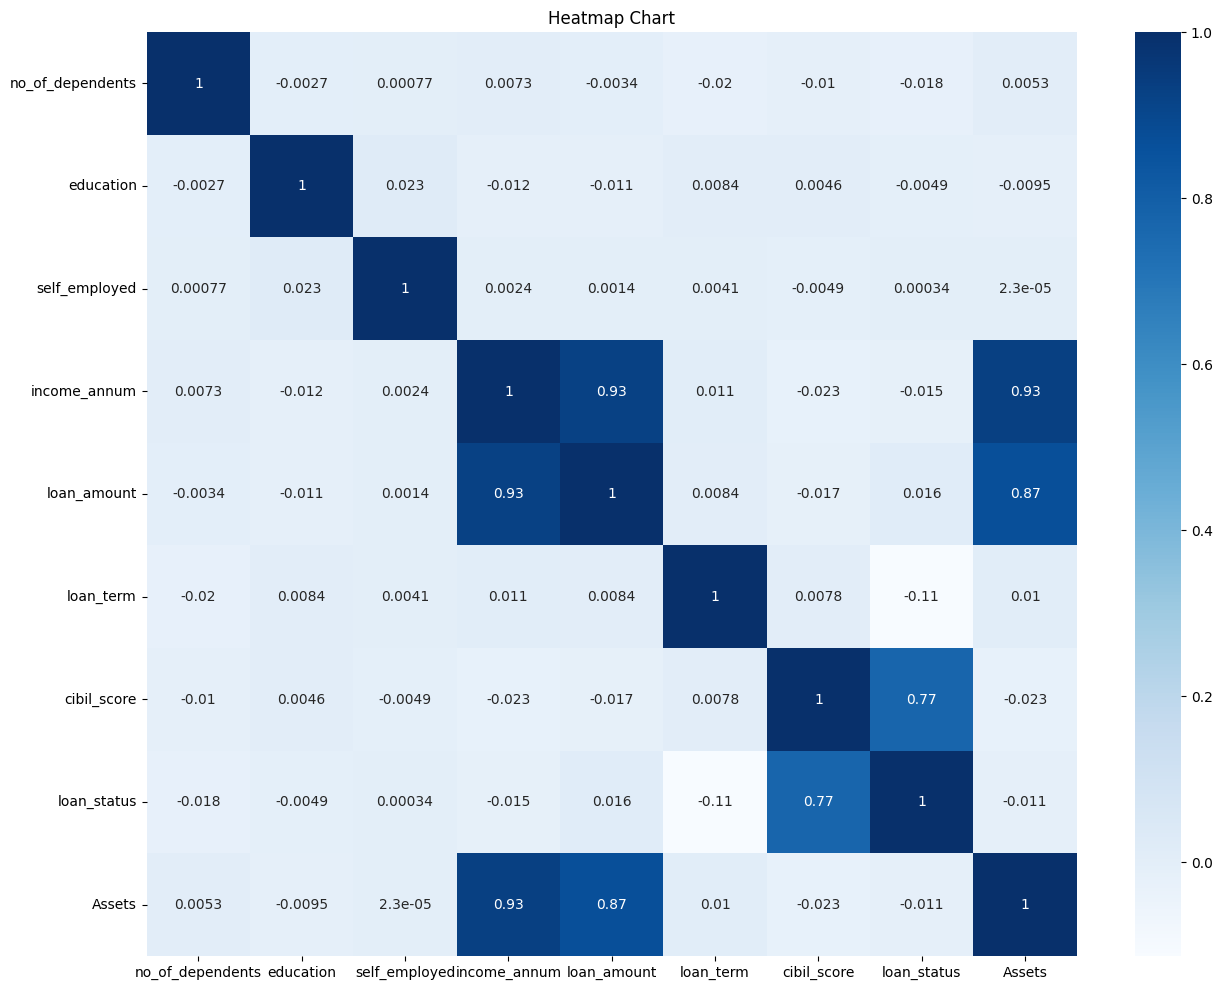

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Kiểm tra các đặc trưng 
df_coff = df.drop(['loan_status'],axis=1)

# corr = df_coff.corr()
corr = df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(data= corr,cmap='Blues',annot=True)
plt.title('Heatmap Chart')

### Đánh giá imbalance data 

/tmp/ipykernel_840/2390467326.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xx, x='loan_status', y = 'count',palette='coolwarm')


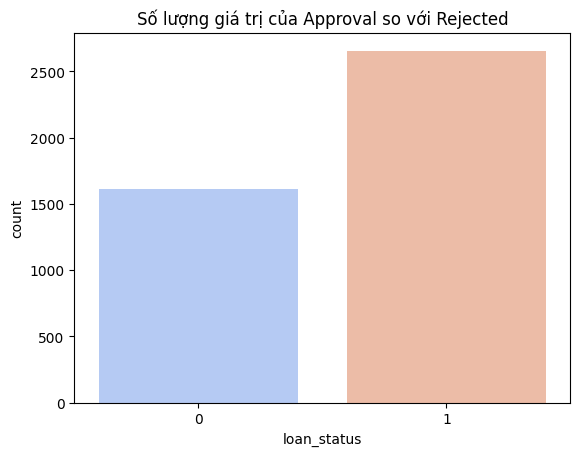

In [ ]:
xx  = df.loan_status.value_counts().reset_index()
sns.barplot(data=xx, x='loan_status', y = 'count',palette='cividis')
plt.title("Số lượng giá trị của Approval so với Rejected")
plt.show()